In [67]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
# Download training and testing data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
train_ds = datasets.FashionMNIST('F_MNIST_data', download=True, train=True, transform=transform)
test_ds = datasets.FashionMNIST('F_MNIST_data', download=True, train=False, transform=transform)

In [68]:
# split train set into training (80%) and validation set (20%)
train_num = len(train_ds)
indices = list(range(train_num))
np.random.shuffle(indices)
split = int(np.floor(0.2 * train_num))
val_idx, train_idx = indices[:split], indices[split:]
len(val_idx), len(train_idx)

(12000, 48000)

In [69]:
# prepare dataloaders
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, sampler=train_sampler)
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_idx)
val_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, sampler=val_sampler)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=True)

torch.Size([1, 28, 28]) torch.Size([64])


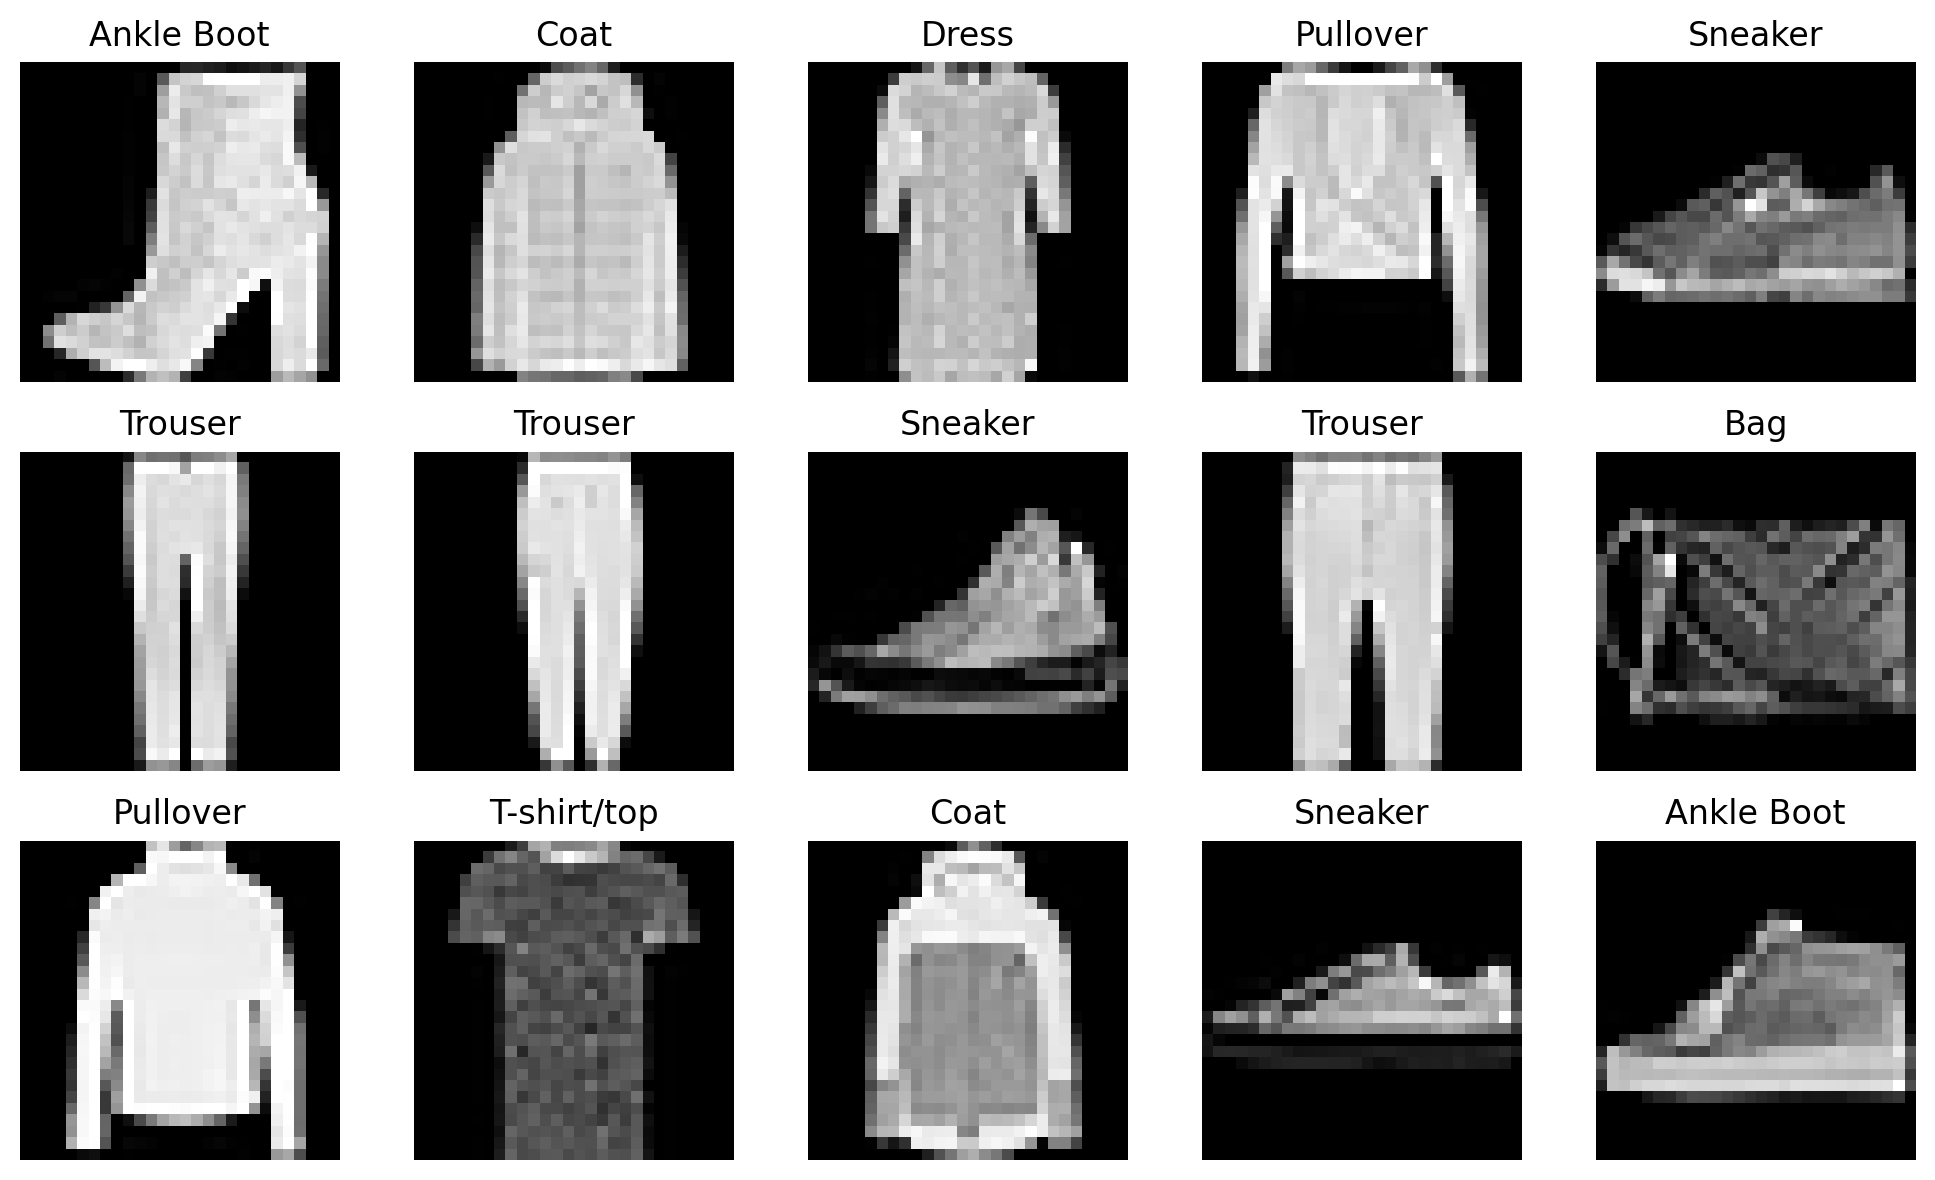

In [70]:
# data labeling and visualization
image, label = next(iter(train_dl))
print(image[0].shape, label.shape)
desc = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 6))
for i in range(3):
    for j in range(5):
        idx = np.random.randint(len(test_ds))
        image, label = test_ds[idx]
        image = image.numpy().squeeze()
        axes[i, j].imshow(image, cmap='gray')
        axes[i, j].set_title(desc[label])
        axes[i, j].axis('off')
plt.tight_layout()
plt.show()

In [71]:
#model ANN
def network():
    model = nn.Sequential(OrderedDict([('fc1', nn.Linear(784, 128)),
                                       ('relu1', nn.ReLU()),
                                       ('drop1', nn.Dropout(0.25)),                                       
                                       ('fc2', nn.Linear(128, 64)),
                                       ('relu2', nn.ReLU()),
                                       ('drop1', nn.Dropout(0.25)),                                       
                                       ('output', nn.Linear(64, 10)),
                                       ('logsoftmax', nn.LogSoftmax(dim=1))]))
    # Use GPU if available
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)

    # define the criterion and optimizer
    loss_fn = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.003)

    return model, loss_fn, optimizer, device  

In [72]:
model, loss_fn, optimizer, device = network()
print(model)

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (drop1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)


In [73]:
def train_validate(model, loss_fn, optimizer, trainloader, testloader, device, n_epochs=25):
    train_losses = []
    test_losses = []
    for epoch in range(n_epochs):
        # Set mode to training - Dropouts will be used here
        model.train()
        train_epoch_loss = 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            # flatten the images to batch_size x 784
            images = images.view(images.shape[0], -1)
            # forward pass
            outputs = model(images)
            # backpropogation
            train_batch_loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            train_batch_loss.backward()
            # Weight updates
            optimizer.step()
            train_epoch_loss += train_batch_loss.item()
        else:
            train_epoch_loss = train_epoch_loss/len(trainloader)

            # Now Validate on testset
            with torch.no_grad():
                test_epoch_acc = 0
                test_epoch_loss = 0
                model.eval()
                for images, labels in testloader:
                    images, labels = images.to(device), labels.to(device)                    
                    images = images.view(images.shape[0], -1)
                    test_outputs = model(images)
                    test_batch_loss = loss_fn(test_outputs, labels)
                    test_epoch_loss += test_batch_loss
                    proba = torch.exp(test_outputs)
                    _, pred_labels = proba.topk(1, dim=1)
                    result = pred_labels == labels.view(pred_labels.shape)
                    batch_acc = torch.mean(result.type(torch.FloatTensor))
                    test_epoch_acc += batch_acc.item()
                else:
                    test_epoch_loss = test_epoch_loss/len(testloader)
                    test_epoch_acc = test_epoch_acc/len(testloader)
                    train_losses.append(train_epoch_loss)
                    test_losses.append(test_epoch_loss)
                    print(f'Epoch: {epoch} -> train_loss: {train_epoch_loss:.19f}, val_loss: {test_epoch_loss:.19f}, ',
                          f'val_acc: {test_epoch_acc*100:.2f}%')
    # Finally plot losses
    plt.plot(train_losses, label='train-loss')
    plt.plot(test_losses, label='val-loss')
    plt.legend()
    plt.show()

Epoch: 0 -> train_loss: 0.5714163072903950535, val_loss: 0.4417881667613983154,  val_acc: 84.17%
Epoch: 1 -> train_loss: 0.4578619418541590158, val_loss: 0.3969916105270385742,  val_acc: 85.26%
Epoch: 2 -> train_loss: 0.4305440575877825249, val_loss: 0.3825576603412628174,  val_acc: 85.81%
Epoch: 3 -> train_loss: 0.4023950014313061874, val_loss: 0.3857640922069549561,  val_acc: 85.53%
Epoch: 4 -> train_loss: 0.3984977669517199006, val_loss: 0.3875675201416015625,  val_acc: 85.28%
Epoch: 5 -> train_loss: 0.3813240049084027361, val_loss: 0.3588474094867706299,  val_acc: 87.15%
Epoch: 6 -> train_loss: 0.3763663161595662277, val_loss: 0.3689757883548736572,  val_acc: 86.36%
Epoch: 7 -> train_loss: 0.3633543167809645258, val_loss: 0.3558971285820007324,  val_acc: 86.64%
Epoch: 8 -> train_loss: 0.3555649459958076242, val_loss: 0.3480656445026397705,  val_acc: 87.23%
Epoch: 9 -> train_loss: 0.3514980807999769641, val_loss: 0.3627128601074218750,  val_acc: 86.48%
Epoch: 10 -> train_loss: 0.346

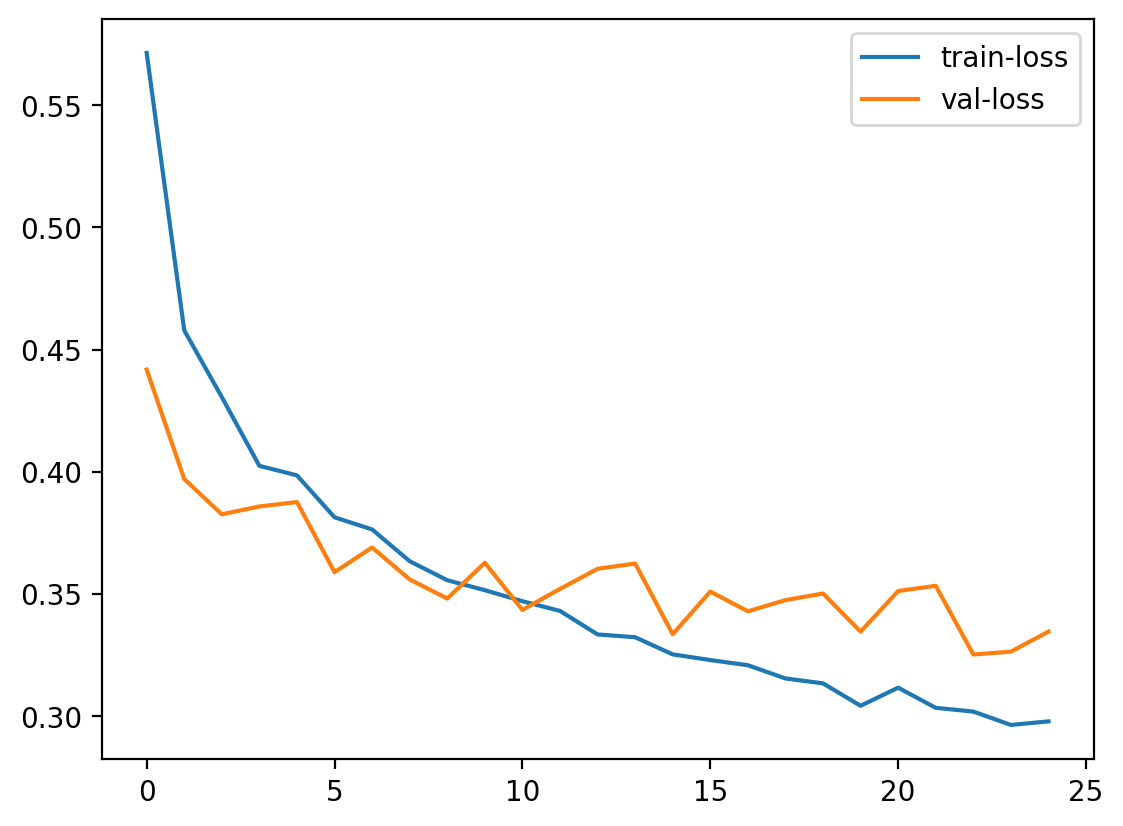

In [74]:
# Train and validate
train_validate(model, loss_fn, optimizer, train_dl, val_dl, device)

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      1000
           1       0.99      0.96      0.98      1000
           2       0.80      0.78      0.79      1000
           3       0.84      0.91      0.87      1000
           4       0.78      0.82      0.80      1000
           5       0.95      0.95      0.95      1000
           6       0.71      0.69      0.70      1000
           7       0.91      0.97      0.94      1000
           8       0.96      0.97      0.97      1000
           9       0.97      0.91      0.94      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



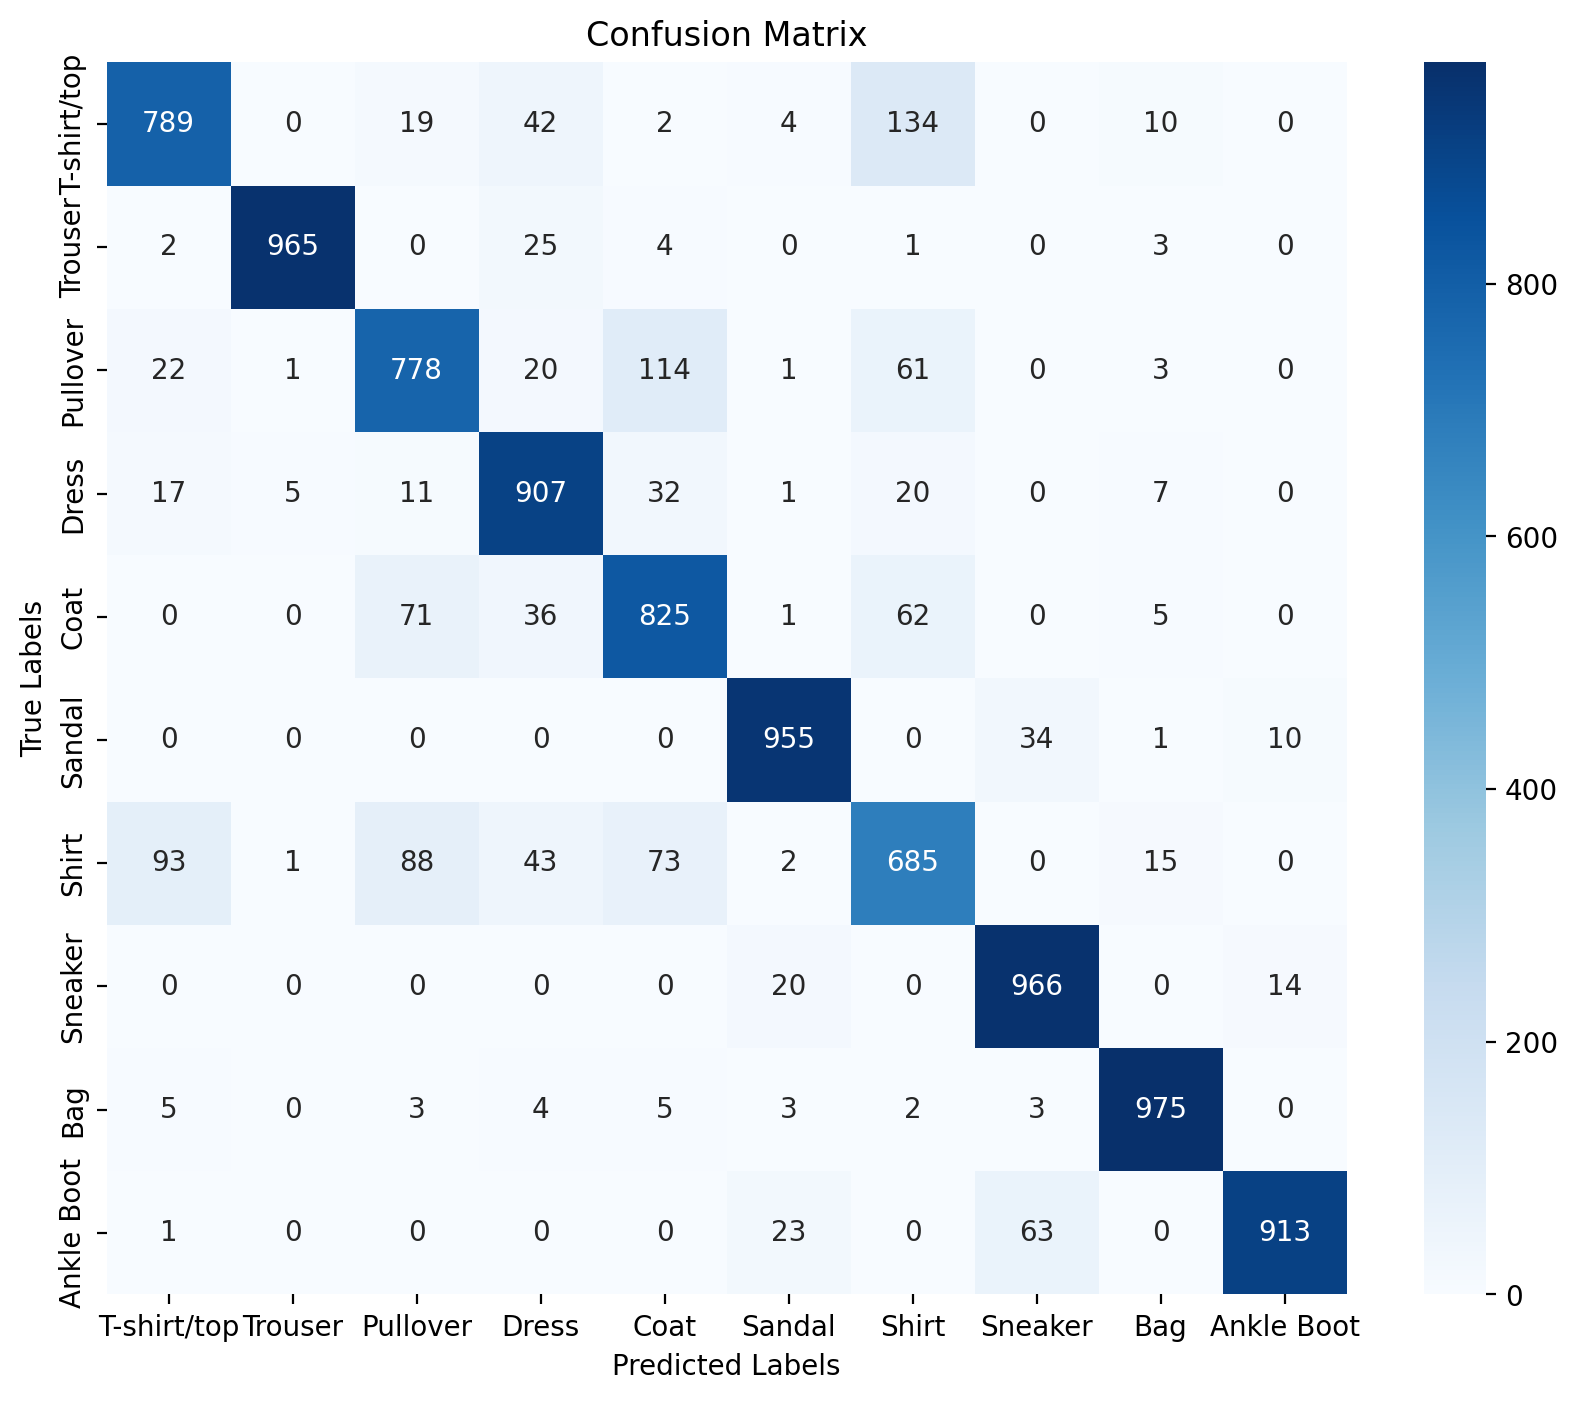

In [75]:
with torch.no_grad():
    all_pred_labels = []
    all_true_labels = []
    batch_acc = []
    model.eval()
    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device)
        # flatten images to batch_size x 784
        images = images.view(images.shape[0], -1)
        # make predictions and get probabilities
        proba = torch.exp(model(images))
        # extract the class associted with highest probability
        _, pred_labels = proba.topk(1, dim=1)
        # compare actual labels and predicted labels
        result = pred_labels == labels.view(pred_labels.shape)
        acc = torch.mean(result.type(torch.FloatTensor))
        batch_acc.append(acc.item())
        # append predicted and true labels
        all_pred_labels.extend(pred_labels.cpu().numpy().flatten())
        all_true_labels.extend(labels.cpu().numpy().flatten())

# classification report
print("Classification Report:")
print(classification_report(all_true_labels, all_pred_labels))

# confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=desc, yticklabels=desc)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [77]:
# prepare dataloaders for cnn model
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, sampler=train_sampler)
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_idx)
val_dl = torch.utils.data.DataLoader(train_ds, batch_size=128, sampler=val_sampler)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=128, shuffle=True)

Epoch: 1/25, Training Loss: 0.549934, Validation Loss: 0.379483
Epoch: 2/25, Training Loss: 0.354789, Validation Loss: 0.316220
Epoch: 3/25, Training Loss: 0.308260, Validation Loss: 0.293680
Epoch: 4/25, Training Loss: 0.273431, Validation Loss: 0.276923
Epoch: 5/25, Training Loss: 0.253749, Validation Loss: 0.271714
Epoch: 6/25, Training Loss: 0.236587, Validation Loss: 0.263237
Epoch: 7/25, Training Loss: 0.221478, Validation Loss: 0.266826
Epoch: 8/25, Training Loss: 0.205014, Validation Loss: 0.248790
Epoch: 9/25, Training Loss: 0.190711, Validation Loss: 0.265861
Epoch: 10/25, Training Loss: 0.180468, Validation Loss: 0.243660
Epoch: 11/25, Training Loss: 0.167151, Validation Loss: 0.251746
Epoch: 12/25, Training Loss: 0.157006, Validation Loss: 0.247958
Epoch: 13/25, Training Loss: 0.146929, Validation Loss: 0.249365
Epoch: 14/25, Training Loss: 0.138720, Validation Loss: 0.278728
Epoch: 15/25, Training Loss: 0.131140, Validation Loss: 0.274821
Epoch: 16/25, Training Loss: 0.123

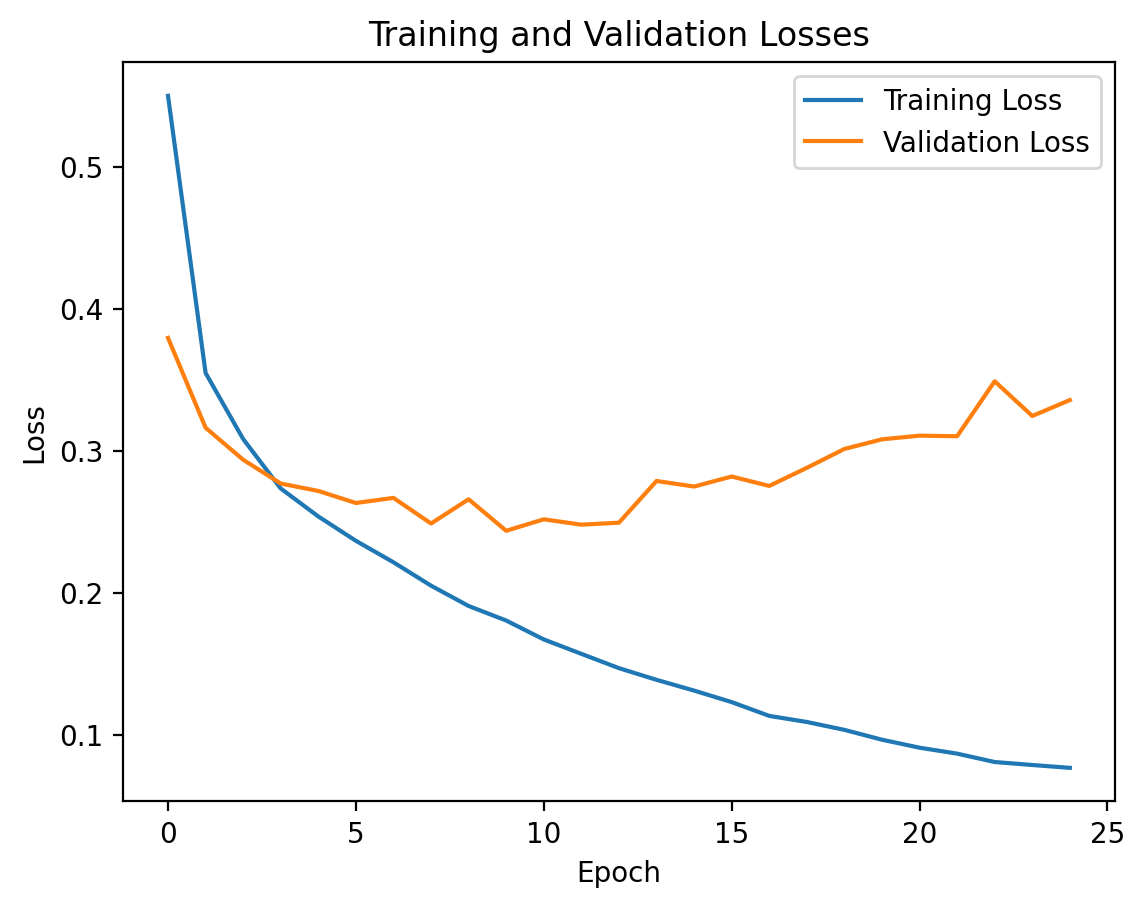

In [78]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.maxpool(self.relu(self.conv1(x)))
        x = self.maxpool(self.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Instantiate the CNN model
model = CNN()

# Use GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

# Define the criterion and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the CNN model
def train_model(model, loss_fn, optimizer, trainloader, testloader, device, n_epochs=25):
    train_losses = []
    test_losses = []
    for epoch in range(n_epochs):
        # Set mode to training
        model.train()
        train_epoch_loss = 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_epoch_loss += loss.item()
        train_epoch_loss /= len(trainloader)
        train_losses.append(train_epoch_loss)

        # Validate on test set
        model.eval()
        test_epoch_loss = 0
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                test_epoch_loss += loss.item()
        test_epoch_loss /= len(testloader)
        test_losses.append(test_epoch_loss)

        print(f'Epoch: {epoch+1}/{n_epochs}, Training Loss: {train_epoch_loss:.6f}, Validation Loss: {test_epoch_loss:.6f}')
    
    # Plot losses
    plt.plot(train_losses, label='train-loss')
    plt.plot(test_losses, label='val-loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

# Train the model
train_model(model, loss_fn, optimizer, train_dl, test_dl, device)
# Evaluate the CNN model
def evaluate_model(model, testloader, device):
    model.eval()
    all_pred_labels = []
    all_true_labels = []
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, pred_labels = torch.max(outputs, 1)
            all_pred_labels.extend(pred_labels.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())
    return all_true_labels, all_pred_labels

# Get true and predicted labels
true_labels, pred_labels = evaluate_model(model, test_dl, device)

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1000
           1       0.99      0.98      0.98      1000
           2       0.86      0.89      0.87      1000
           3       0.91      0.92      0.92      1000
           4       0.86      0.87      0.87      1000
           5       0.99      0.97      0.98      1000
           6       0.81      0.71      0.76      1000
           7       0.95      0.98      0.97      1000
           8       0.98      0.98      0.98      1000
           9       0.98      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



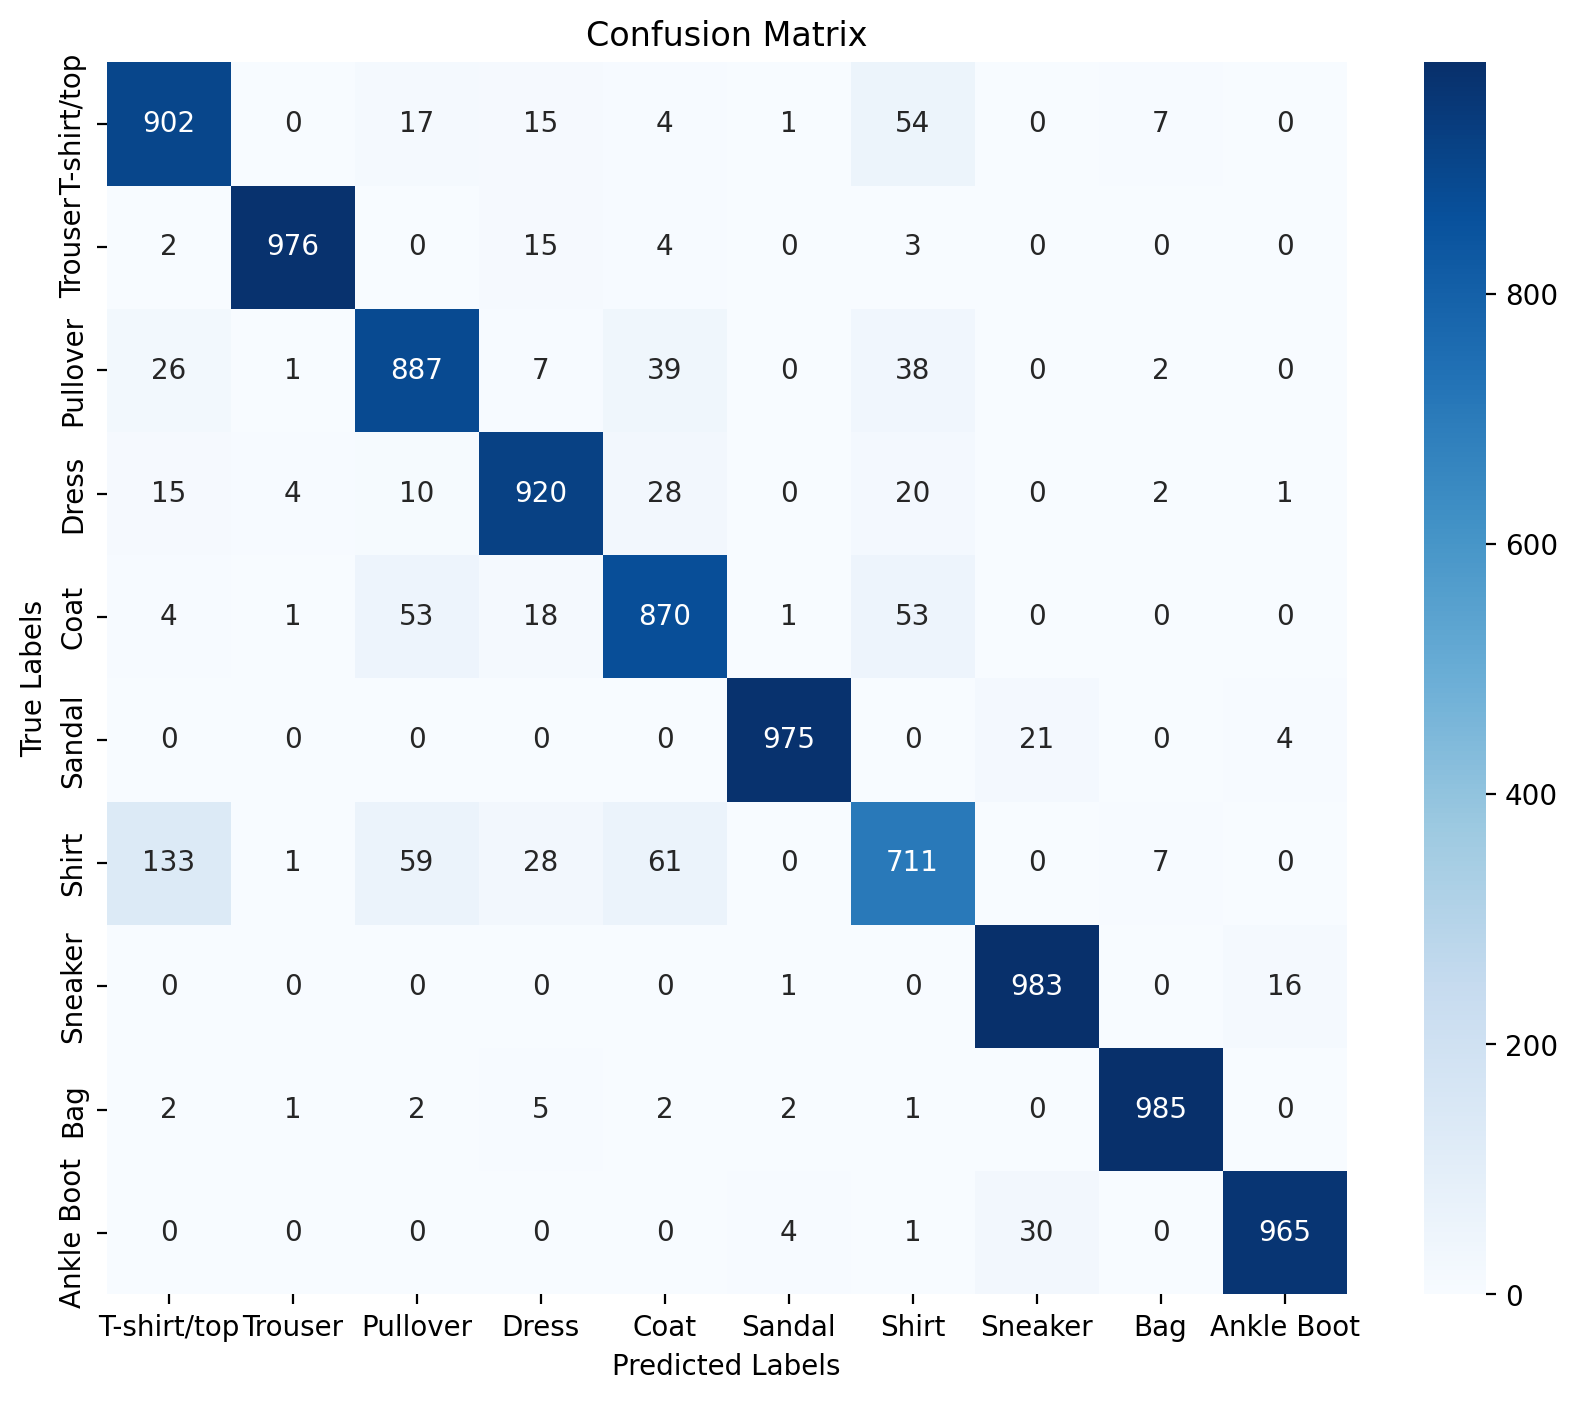

In [79]:

# classification report
print("Classification Report:")
print(classification_report(true_labels, pred_labels))
# confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",xticklabels=desc, yticklabels=desc)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()